# Module 2: Load and interact with velocity fields

In [2]:
include("module_01.jl")

1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 4×4×4 halo:
├── immersed_boundary: GridFittedBoundary{Field{Center, Center, Center, Nothing, LatitudeLongitudeGrid{Float64, Periodic, Bounded, Bounded, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, Float64, Float64, Float64, Float64, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, CPU}, Tuple{Colon, Colon, Colon}, OffsetArrays.OffsetArray{Bool, 3, Array{Bool, 3}}, Bool, FieldBoundaryConditions{BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryConditions.Periodic, Nothing}, BoundaryCondition{Oceananigans.BoundaryCondit

### Download velocity datasets

To download the (precomputed) velocity datasets we, once again, use the `DataDeps` package

In [18]:
onlinepath = "https://github.com/simone-silvestri/coessing-data/raw/main/"

dh = DataDep("quarter_degree_velocity_timeseries",
     "Mean velocity fields for the global latitude longitude simulation",
     onlinepath * "prescribed_mean_fields.jld2"
)

DataDeps.register(dh)

datadep"quarter_degree_velocity_timeseries"

file_velocities = jldopen(@datadep_str "quarter_degree_velocity_timeseries/prescribed_mean_fields.jld2")


┌ Warning: Over-writing registration of the datadep
│   name = quarter_degree_velocity_timeseries
└ @ DataDeps /Users/simonesilvestri/.julia/packages/DataDeps/jDkzU/src/registration.jl:15


JLDFile /Users/simonesilvestri/.julia/datadeps/quarter_degree_velocity_timeseries/prescribed_mean_fields.jld2 (read-only)
 ├─🔢 um
 └─🔢 vm

The file contains two datasets:

- um
- vm

which can be accessed by indexing `field` with a string (`field["um"]`). <br>
these datasets are the _mean_ velocities at the ocean surface averaged over 10 years.
Let's assign these datasets to two variables and look at their structure

In [53]:
const Um = file_velocities["um"]
const Vm = file_velocities["vm"]

@show typeof(Um);
@show size(Um);
@show typeof(Vm)
@show size(Vm);

typeof(Um) = Array{Float64, 3}
size(Um) = (1440, 600, 1)
typeof(Vm) = Array{Float64, 3}
size(Vm) = (1440, 601, 1)


Both of them are three dimensional Arrays. 
Oceananigans always works with three dimensional data for simplicity, a two dimensional
dataset (for example a x-y datatset) will be defined as an array of size `(Nx, Ny, 1)`
(as in this case)

These velocities have `0` at the indices corresponding to the continent's position.

To better visualize the fields, let's create a "continent mask" to overlay to our velocity. <br>
We want to have a mask that has all the elements for which `bathymetry > 0` (over sea level) equal to `NaN`s (these will be our continents) <br> and all elements for which `bathymetry < 0` (the ocean) equal to `0`. 

In [64]:
mask = zeros(Nx, Ny)
mask[ bathymetry .> 0 ] .= NaN
mask[ bathymetry .< 0 ] .= 0.0

@show typeof(mask);
@show size(mask);

typeof(mask) = Matrix{Float64}
size(mask) = (1440, 600)


Our masked velocity field will just be `Um + mask1`. <br>
Note that `Um` is a 3D array while mask only a 2D array (2D Array and Matrix are the same thing)

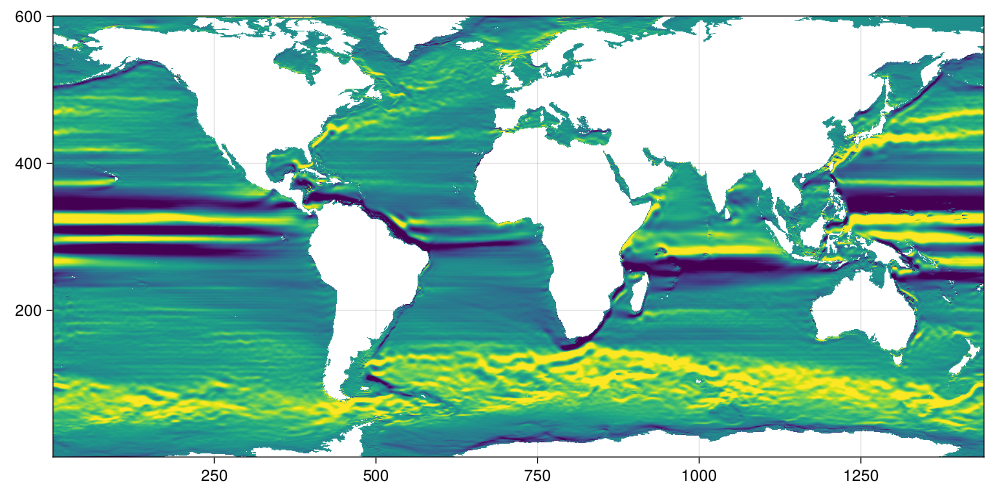

In [54]:
# Mean zonal velocity
u = Um[:, :, 1] .+ mask

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, u, colorrange = (-0.2, 0.2))
current_figure()

The same thing can be done for the meridional velocity `v`. Note that `Um` and `Vm` do not have the same dimensions! 

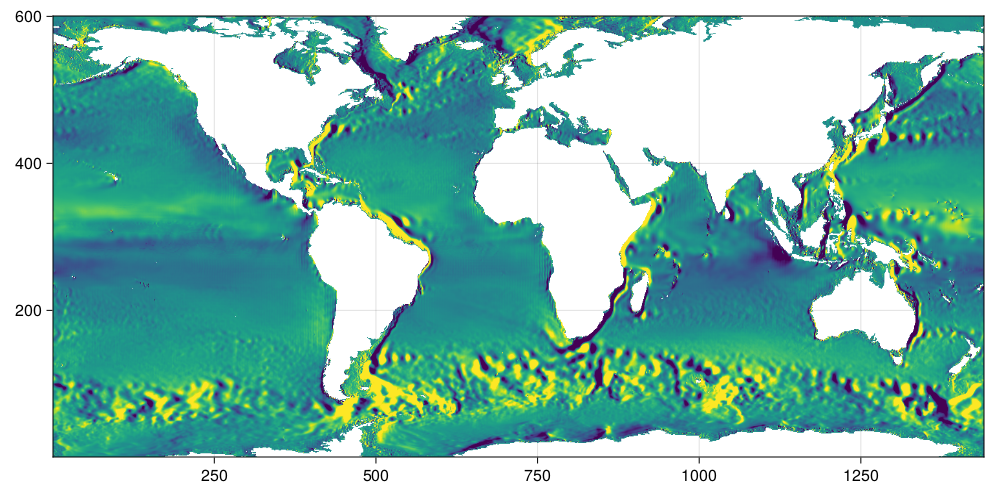

In [10]:
# Mean meridional velocity
v = Vm[:, 1:end-1, 1] .+ mask

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, v, colorrange = (-0.1, 0.1))
current_figure()

u and v are a little bit different because they are a time series. Let's take a look at this data!

### Introduction to data structures in Oceananigans: Fields

Oceananigans represents variables connected to a particular grid with a `Field` type. <br> 
Fields are essentially containers which include the grid, the data allocated on the grid (the previously seen 3D arrays), <br>
as well as the eventual boundary conditions.

We can define empty fields (i.e., empty containers) for our velocities and fill them with the velocity data we loaded in

In [60]:
U = XFaceField(grid)
V = YFaceField(grid)

set!(U, Um)
set!(V, Vm)

1440×601×1 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 4×4×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1448×609×9 OffsetArray(::Array{Float64, 3}, -3:1444, -3:605, -3:5) with eltype Float64 with indices -3:1444×-3:605×-3:5
    └── max=2.11723, min=-1.68651, mean=0.00532223

### Combining fields

Fields are handy because they can be combined through expressions. <br>
as an example, let's calculate the mean kinetic energy at the surface defined as

$$K = 0.5 * (U^2 + V^2)$$

In [61]:
K = Field(0.5 * (U^2 + V^2))
compute!(K)

1440×600×1 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 1440×600×1 ImmersedBoundaryGrid{Float64, Periodic, Bounded, Bounded} on CPU with 4×4×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: ZeroFlux, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
├── operand: BinaryOperation at (Face, Center, Center)
├── status: time=0.0
└── data: 1448×608×9 OffsetArray(::Array{Float64, 3}, -3:1444, -3:604, -3:5) with eltype Float64 with indices -3:1444×-3:604×-3:5
    └── max=1.98573, min=0.0, mean=0.00737816

Now let's see how kinetic energy of the surface looks like. <br>
We can plot is trough Makie as we have done before, but we have to extract data from the field to plot it! <br>

To access the data associated with an Oceananigans field we can use the function `interior`

typeof(k) = SubArray{Float64, 3, Array{Float64, 3}, Tuple{UnitRange{Int64}, UnitRange{Int64}, UnitRange{Int64}}, false}


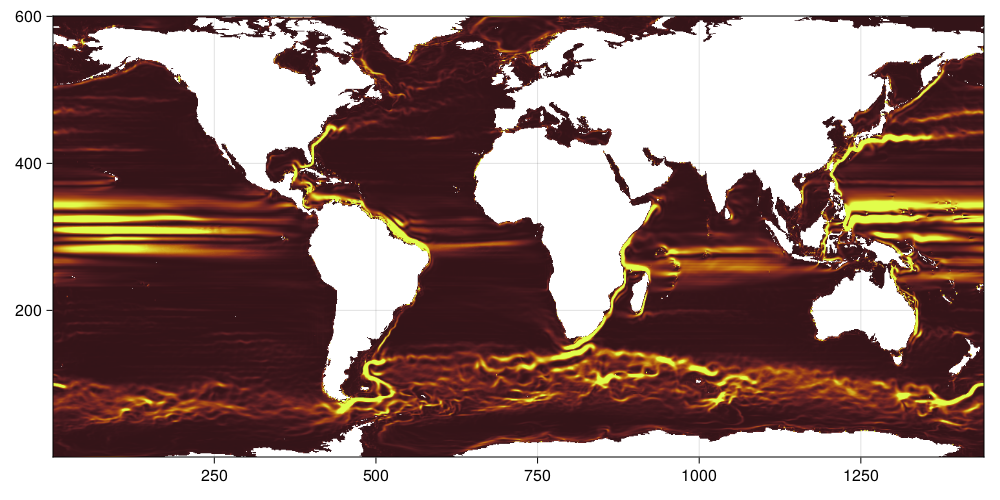

In [65]:
k = interior(K)

# The data associated with a field is always three dimensional!
@show typeof(k);

fig = Figure(resolution = (1000, 500))
ax = Axis(fig[1, 1])
heatmap!(ax, k[:, :, 1] .+ mask, colorrange = (0, 0.05), colormap = :solar)

current_figure()

Note that the _interior_ of a field in Oceananigans is a `SubArray`. <br>

A `SubArray` is an array which contains only part of a parent `Array`. <br>
For all purposes a `SubArray` behaves as an `Array` and can be plotted with no problems
through `heatmap`

### Computing derivatives

In the same way we can compute derivatives. <br>
For example, let's calculate and plot the latitudinal derivative of the zonal velocity
$$S = \frac{\partial U}{\partial x}$$

Note that julia supports Unicode. <br>
The differentiation operator in Oceananigans is defined with the $\partial$ symbol. <br>
To write it out in julia, type `\partial` and then press the TAB key

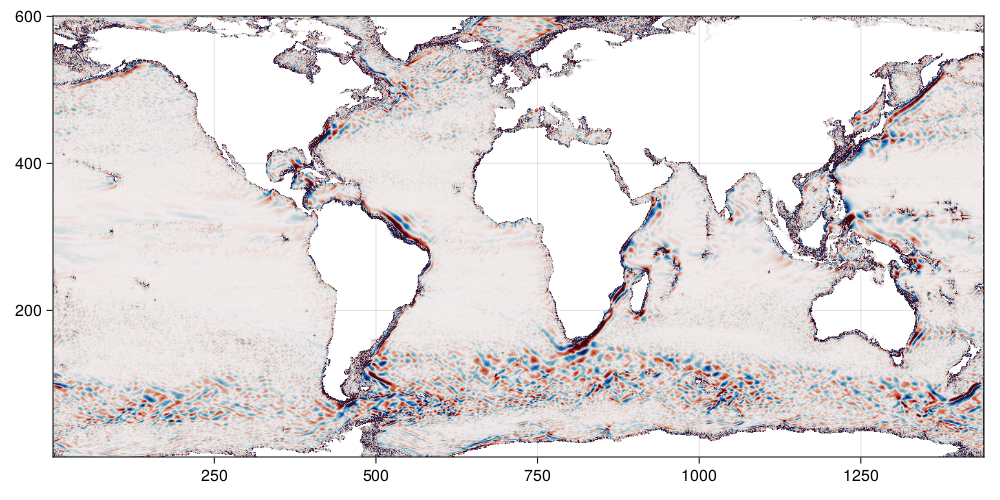

In [63]:
S = Field(∂x(U))
compute!(S)

s = interior(S)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, s[:, :, 1] .+ mask, colorrange = (-2e-6, 2e-6), colormap = :balance)

current_figure()

### Try it yourself

define and plot the z-component of vorticity ($\zeta$) defined as

$$\zeta = \frac{\partial V}{\partial x} - \frac{\partial U}{\partial y}$$

#### Remember!
- the derivative operator in Oceananigans is constructed with \partial+TAB
- heatmap can plot only 2D AbstractArrays (SubArrays are AbstractArrays)
- the data of a field is retrieved by the `interior` function
- Fields are _always_ three dimensional

#### Tips
- You can use the `typeof` and `size` function to check the variable you want to plot is a 2D array (or matrix)
- Use the example above for plotting using `colorrange = (-2e-6, 2e-6)` and `colormap = :blues`
- do not sum the mask (the dimensions of $\zeta$ might be different)

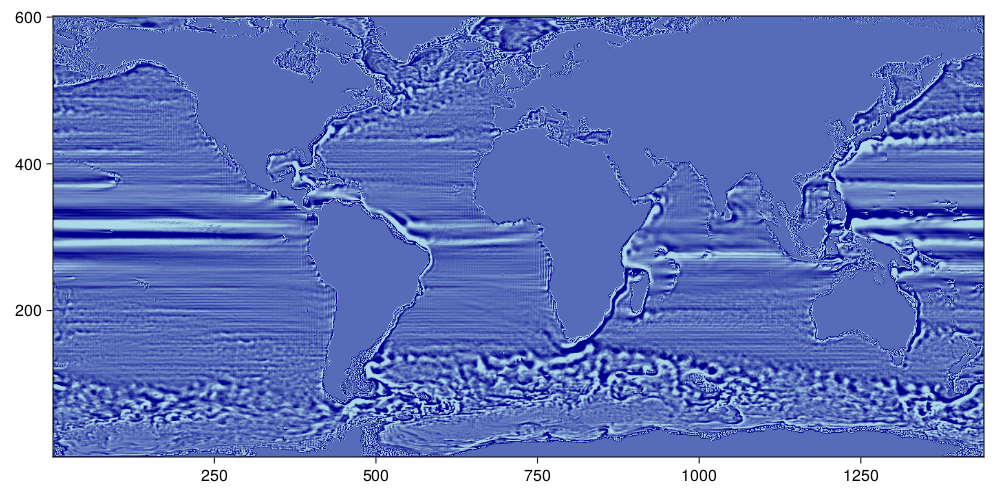

In [73]:
Z = Field(∂x(V) - ∂y(U))
compute!(Z)

z = interior(Z)

fig = Figure(resolution = (1000, 500))
ax  = Axis(fig[1, 1])
heatmap!(ax, z[:, :, 1], colorrange = (-2e-6, 2e-6), colormap = :blues)

current_figure()